In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sma
import statsmodels as sms

from pymatch.Matcher import Matcher

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

/home/phil/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
data_path = "/media/veracrypt1/SPON_dataset_tables/"
plot_path = "plots/"

In [3]:
table2 = pd.read_csv(data_path + "datasets_v2/20190703_analysis_dataset_versandbank_final_cleaned.csv", sep=";")

In [4]:
def prepare_type(df_data):
    # Nominal features
    df_data["sex"] = df_data["sex"].astype("category")
    df_data["familyStatus"] = df_data["familyStatus"].astype("category")
    df_data["employment"] = df_data["employment"].astype("category")
    df_data["housing"] = df_data["housing"].astype("category")
    df_data["east_west"] = df_data["east_west"].astype("category")

    # Ordinal features
    cat_ordtype = pd.api.types.CategoricalDtype(categories=[500, 1000, 2000, 3000, 4000, 5000], ordered=True)

    df_data["monthlyIncome"] = df_data["monthlyIncome"].astype(cat_ordtype)
    df_data["activeLoanAmount"] = df_data["activeLoanAmount"].astype(cat_ordtype)
    df_data["paidOffLoanAmount"] = df_data["paidOffLoanAmount"].astype(cat_ordtype)
    
    return df_data

In [5]:
def do_scatter(fitted, res):
    plt.scatter(fitted, res)
    plt.xlabel("fitted values")
    plt.ylabel("residuals")
    plt.show()
    plt.close()
    

def do_hist(res):
    plt.hist(res)
    plt.xlabel("residuals")
    plt.ylabel("frequency")
    plt.show()
    plt.close()

In [6]:
# Get Cramers V statistics
def get_cramersv(df, feat, feat_name):
    
    X2_list = []
    V_list = []
    ofeats = []

    for ofeat in df.columns:
        
        if ofeat == "plz_num" or ofeat == "plz_two" or ofeat == "nationality_num" or ofeat == feat_name:
            continue

        df_temp = pd.concat([feat, df[ofeat]], axis=1, sort=False).dropna()
        
        conf_tab = pd.crosstab(df_temp[feat_name], df_temp[ofeat])
        
        N = len(df_temp)
        k = np.min(conf_tab.shape)
    
        # chi2 test
        chi2, p, _, _ = stats.chi2_contingency(conf_tab)
        X2_list.append((chi2, p))
        
        # Cramers V
        V = np.sqrt(chi2 / (N*(k-1)))
        V_list.append(V)
        
        ofeats.append(ofeat)

    d = {"X2-test": [i[0] for i in X2_list], "p-value": [i[1] for i in X2_list], "V-test": V_list}
    
    return pd.DataFrame(d, index=ofeats)

In [7]:
def remove_nans(df, ordered=False):
    if ordered:
        return df[df != -1]
    else:
        return df.dropna()

def do_anova(df, nom_feats, metric_feats, ordered=False):
    levene = []
    shapiro = []
    anova = []
    kruskal = []
    feats = []

    if type(nom_feats) == str:
        tmp = df.groupby(nom_feats)
        samples = [tmp.get_group(g) for g in tmp.groups]

        for metric_feat in metric_feats:
            if metric_feat == "permanent_account":
                continue

            if df[metric_feat].dtype.name == "category" or df[metric_feat].dtype.name == "bool":
                continue

            levene.append(stats.levene(*[remove_nans(g[metric_feat],ordered).tolist() for g in samples])[1])
            shapiro.append([stats.shapiro(remove_nans(g[metric_feat],ordered))[1] for g in samples])
            anova.append(stats.f_oneway(*[remove_nans(g[metric_feat],ordered).tolist() for g in samples])[1])
            kruskal.append(stats.kruskal(*[remove_nans(g[metric_feat],ordered).tolist() for g in samples])[1])
            feats.append(metric_feat)
        
    if type(metric_feats) == str:
        
        for nom_feat in nom_feats:
            tmp = df.groupby(nom_feat)
            samples = [tmp.get_group(g) for g in tmp.groups]
            
            to_drop = []
            for idx, g in enumerate(samples):
                if len(g[metric_feats].dropna()) < 5:
                    to_drop.append(idx)
                    
            for idx in to_drop:
                del samples[idx]
            if len(samples) < 2:
                print("Too few groups for: %s" % nom_feat)
                continue
            
            levene.append(stats.levene(*[g[metric_feats].dropna().tolist() for g in samples])[1])
            shapiro.append([stats.shapiro(g[metric_feats].dropna())[1] for g in samples])
            anova.append(stats.f_oneway(*[g[metric_feats].dropna().tolist() for g in samples])[1])
            kruskal.append(stats.kruskal(*[g[metric_feats].dropna().tolist() for g in samples])[1])
            feats.append(nom_feat)

    d = {"F-test":anova, "H-test":kruskal, "Normal-test": shapiro, "Variance-test": levene}
    anova_stats = pd.DataFrame(d, index=feats)

    return anova_stats

In [8]:
def do_utests(df, treat, covariates, attr):
    
    print("control/test difference in mean using a significance niveau of a=.1\n")
    print("------------")
    print("Results:")
    
    cases = []
    
    for i in covariates:
        if i=="id" or i=="east_west" or i=="sex" or i=="bin_age":
            continue
                    
        t = df[df[treat]==attr[0]][i]
        t = t.dropna()

        c = df[df[treat]==attr[1]][i]
        c = c.dropna()
        
        # Use mann-whitney-u test
        stat, pval = stats.mannwhitneyu(t, c, alternative='two-sided')
        
        cases.append([treat, i, stat, pval])
        
        if pval <= 0.1 and len(t) > 1 and len(c) > 1 and t.max() - t.min() != 0 and c.max() - c.min() != 0:
            print("Test Sample:", len(t), "Span:", t.min(), t.max(), "Mean:", t.mean())
            print("Control Sample:", len(c), "Span:", c.min(), c.max(), "Mean:", c.mean())
            print(i, "- U-test:", stat, pval)
            #print("Coens-D Effect:", (c.mean() - t.mean())/np.sqrt((2**2 + 3**2)/2))
            print()
            
    return pd.DataFrame(cases, columns=["social feature", "covariate", "u-statistic", "p-value"]).sort_values("p-value", ascending=False)

In [9]:
def get_feature_lists(domain):
    # Separate Columns into data types as well as predictors and target

    nominal = ["sex", "east_west", "mailOrder"]
    nom_idx = len(nominal)

    metric = ['monthlyIncome', 'age', 'relocation', # questionnaire data
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan', # feature counts
              domain+'_req', 'finance_year', # request/time counts
              'credit_days', 'credit_card_days', 'giro_days'] # time-based

    target = ["score"]



    # Separate Columns into counts (discrete with zero-inflation) and non-counts

    counts = ['relocation', 
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan',
              domain+'_req', 'finance_year']

    non_counts = ["female", "east", "mailOrder",
                  'monthlyIncome', 'age', 
                  'credit_days', 'credit_card_days', 'giro_days']
    
    return nominal, nom_idx, metric, target, counts, non_counts

In [10]:
table2 = prepare_type(table2)

In [11]:
table2.columns

Index(['id', 'date', 'table', 'customer', 'feature', 'domain', 'version',
       'score', 'value', 'level', 'meaning', 'stoerung', 'kredit_jahr',
       'kredit_nutzung', 'kredit_historie', 'allgemein', 'anschrift',
       'all_columns_text', 'activeLoanAmount', 'admonition', 'cashing',
       'employment', 'executionProceedings', 'familyStatus', 'housing',
       'insolvencyProceedings', 'mailOrder', 'migrationBackground',
       'monthlyIncome', 'numberOfActiveLoans', 'numberOfChildren',
       'numberOfCreditCards', 'numberOfGiroAccounts',
       'numberOfMobileContracts', 'numberOfPaidOffLoans', 'paidOffLoanAmount',
       'plz', 'relocation', 'schufaDate', 'sex', 'yearOfBirth', 'foreigner',
       'basisscore', 'plz_one', 'east_west', 'age', 'age_class', 'age_gen',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       

In [12]:
# As an example we use versandhandel V1
domain = "Versandhandel"
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

In [13]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)

relevant_feats = target + nominal + metric

In [14]:
df_data.columns[-26:]

Index(['request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       'Freiberufler_req', 'Genossenschaftsbanken_req', 'Handel_req',
       'Hypothekengeschäft_req', 'Kleingewerbetreibende_req', 'Sparkassen_req',
       'Sparkassen/Genossenschaftsbanken_req',
       'Telekommunikationsunternehmen_req', 'Versandhandel_req', 'credit_days',
       'credit_card_days', 'giro_days', 'finance_year'],
      dtype='object')

In [15]:
df_data.iloc[:, -26:].isna().sum().sum()

0

In [16]:
Xy = df_data[["id"]+relevant_feats]
print(Xy.shape)
Xy = Xy.dropna()
print(Xy.shape)

Xy.monthlyIncome = Xy.monthlyIncome.cat.codes

(1615, 25)
(1255, 25)


## Correlation Analysis
### Age

In [17]:
# relevant - pearson
Xy.corr()[["age", "score"]].to_csv("matching_outputs/age_SCHUFA_features_pearson.csv", sep=";")
Xy.corr()[["age", "score"]]

,age,score
score,0.463127,1.000000
mailOrder,-0.064226,-0.122974
monthlyIncome,0.443531,0.282208
age,1.000000,0.463127
relocation,-0.390056,-0.265175
request,0.061606,-0.121709
banking_connection,0.000877,-0.022188
business_relation,-0.021935,-0.117956
conditions,0.014006,-0.120837
credit_card,0.081579,0.201494


In [18]:
# relevant - spearman
Xy.corr("spearman")[["age", "score"]].to_csv("matching_outputs/age_SCHUFA_features_spearman.csv", sep=";")
Xy.corr("spearman")[["age", "score"]]

,age,score
score,0.479576,1.000000
mailOrder,-0.056951,-0.119153
monthlyIncome,0.499157,0.271862
age,1.000000,0.479576
relocation,-0.399150,-0.277202
request,0.038722,-0.171715
banking_connection,0.020364,-0.020195
business_relation,-0.022843,-0.120925
conditions,0.004914,-0.150630
credit_card,0.101069,0.246246


SCHUFA-Score correlation:
- sex
- age
- relocation
- business_relation
- secured_loan
- identity
- solvency
- credit_card
- Versandhandel_req
- credit_card_days
- giro_days

Covariates for age:
- relocation
- secured_loan
- unsecured_loan
- identity
- solvency
- credit_card_aggr
- credit_aggr
- credit_days
- credit_card_days
- giro_days

### Sex

In [20]:
do_utests(Xy, "sex", target+metric, ["female", "male"])

control/test difference in mean using a significance niveau of a=.1

------------
Results:
Test Sample: 113 Span: 206.0 953.0 Mean: 627.6902654867257
Control Sample: 1142 Span: 14.0 910.0 Mean: 518.3073555166375
score - U-test: 82081.0 1.7760748162890821e-06

Test Sample: 113 Span: 0 5 Mean: 2.0973451327433628
Control Sample: 1142 Span: 0 5 Mean: 2.9238178633975482
monthlyIncome - U-test: 46763.0 8.917016041502299e-07

Test Sample: 113 Span: 0.0 16.0 Mean: 1.8141592920353982
Control Sample: 1142 Span: 0.0 41.0 Mean: 2.682136602451839
request - U-test: 57274.5 0.03814696386472096

Test Sample: 113 Span: 0.0 13.0 Mean: 0.21238938053097345
Control Sample: 1142 Span: 0.0 20.0 Mean: 0.4500875656742557
conditions - U-test: 60529.0 0.07923955801824327

Test Sample: 113 Span: 0.0 3.0 Mean: 0.3274336283185841
Control Sample: 1142 Span: 0.0 7.0 Mean: 0.4290718038528897
telecom - U-test: 59554.5 0.0993150730027506

Test Sample: 113 Span: 0.0 3.0 Mean: 0.18584070796460178
Control Sample: 1142 Span

,social feature,covariate,u-statistic,p-value
12,sex,secured_loan,64631.5,9.561139e-01
5,sex,banking_connection,64706.5,9.028813e-01
20,sex,giro_days,63712.0,8.226065e-01
19,sex,credit_card_days,63195.5,7.049363e-01
16,sex,Versandhandel_req,63513.5,6.396286e-01
3,sex,relocation,66360.5,6.099989e-01
18,sex,credit_days,63125.5,6.019529e-01
10,sex,global_credit,65225.0,5.870978e-01
8,sex,credit_card,62595.5,5.745290e-01
11,sex,identity,62507.5,4.595032e-01


Covariates for sex vs score:
- score, monthlyIncome, request, conditions, telecom, finance_year

## Matching as Subsampling Method
We want to see if we can get a complete subsample using all possible covariates.

In [21]:
covariates = [feat for feat in relevant_feats if feat not in ["sex", "score"]]

In [22]:
df_match = Xy[covariates + ["id", "sex"]].dropna()
print(df_match.shape)

(1255, 24)


In [23]:
df_match["sex"] = df_match["sex"].cat.codes.apply(lambda x: abs(x-1))

In [24]:
# Treatment-Group
test_female = df_match[df_match["sex"]==1].reset_index(drop=True)
# Control-Group
control_male = df_match[df_match["sex"]==0].reset_index(drop=True)

In [25]:
test_female.shape, control_male.shape

((113, 24), (1142, 24))

In [26]:
test_female.columns

Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'sex'],
      dtype='object')

In [27]:
control_male.sex.unique()

array([0])

In [28]:
match = Matcher(test=test_female, control=control_male, yvar="sex", exclude=["id"])

Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_card_days+giro_days
n majority: 1142
n minority: 113


In [29]:
np.random.seed(42)

# We subsample male because of significant class imbalance, therefore we fit multiple models with random subsamples
match.fit_scores(balance=True, nmodels=150)

Fitting Models on Balanced Samples: 1\150Error: Unable to coerce to Series, length must be 1: given 226
Fitting Models on Balanced Samples: 1\150Error: Unable to coerce to Series, length must be 1: given 226
Fitting Models on Balanced Samples: 1\150Error: Unable to coerce to Series, length must be 1: given 226
Fitting Models on Balanced Samples: 1\150Error: Unable to coerce to Series, length must be 1: given 226
Fitting Models on Balanced Samples: 1\150Error: Unable to coerce to Series, length must be 1: given 226

Average Accuracy: nan%


There is some separability in the covariates, even though not much (16% over 50%)

In [29]:
match.predict_scores()

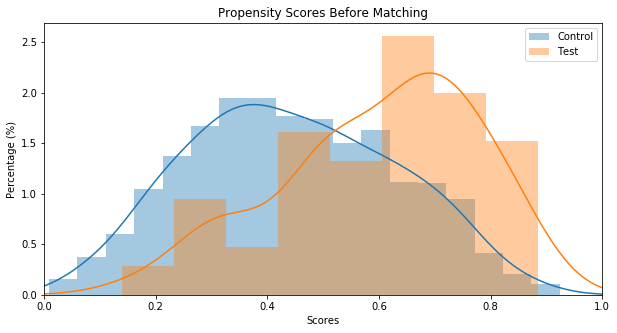

In [30]:
match.plot_scores()

In [31]:
np.arange(0, .01, .001)

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009])

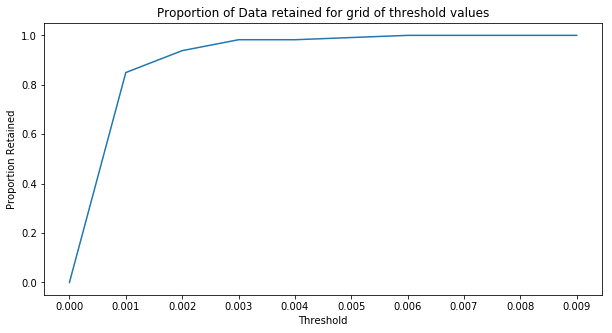

In [32]:
# Train threshold for matching propensity-score
match.tune_threshold(method="random", rng=np.arange(0, .01, .001))

In [33]:
def nn_without_replacement(match_ds, nmatches=1, thresh=0.001):
    # Matching with Nearest-Neighbour (multiple rounds) without replacement 
    # (so we don't assign a control observation multiple times)

    test_scores = match_ds.data[match_ds.data[match_ds.yvar]==True][['id', 'scores']]
    ctrl_scores = match_ds.data[match_ds.data[match_ds.yvar]==False][['id', 'scores']]

    result, match_ids = [], []
    for j in range(nmatches):
        print("Match-Iteration: %d"%(j+1))
        for i in range(len(test_scores)):

            match_id = i

            score = test_scores.iloc[i].scores

            ctrl_diff = abs(ctrl_scores.scores - score).to_frame()
            ctrl_diff["id"] = ctrl_scores.id
            diff_sorted = ctrl_diff.sort_values('scores')

            if diff_sorted.scores.iloc[0] < thresh:
                chosen = diff_sorted.iloc[0].name
                schufa_id = diff_sorted.iloc[0].id
                ctrl_scores = ctrl_scores[ctrl_scores.id!=schufa_id]
            else:
                continue

            if j==0:
                match_ids.extend([i] * (2))
                result.extend([test_scores.index[i]] + [chosen])
            else:
                match_ids.extend([i])
                result.extend([chosen])

    match_ds.matched_data = match_ds.data.loc[result]
    match_ds.matched_data['match_id'] = match_ids
    match_ds.matched_data['record_id'] = match_ds.matched_data.index

In [34]:
def add_weights(match_ds, variable="sex"):
    amount_control_matches = 1/match_ds.matched_data.groupby("match_id")[variable].value_counts().loc[:,0]
    amount_control_matches.name = "weight"
    match_ds.matched_data = match_ds.matched_data.join(amount_control_matches, on="match_id")
    match_ds.matched_data.loc[match_ds.matched_data[variable]==1, "weight"] = 1.

In [35]:
#match.match(method="min", nmatches=2, threshold=0.0003)

In [36]:
nn_without_replacement(match, nmatches=3, thresh=0.0008)

Match-Iteration: 1
Match-Iteration: 2
Match-Iteration: 3


In [37]:
match.record_frequency()

,freq,n_records
0,1,260


In [38]:
match.matched_data.shape

(260, 27)

In [39]:
add_weights(match, variable="sex")

In [40]:
match.matched_data.sort_values(["match_id", "sex"]).head(20)[["match_id", "record_id", "weight"]]

,match_id,record_id,weight
825,0,825,0.500000
448,0,448,0.500000
0,0,0,1.000000
158,1,158,0.500000
884,1,884,0.500000
1,1,1,1.000000
1141,2,1141,0.333333
1247,2,1247,0.333333
603,2,603,0.333333
2,2,2,1.000000


,var,before,after
0,east_west,0.010146,0.75003
1,mailOrder,0.451172,0.62845


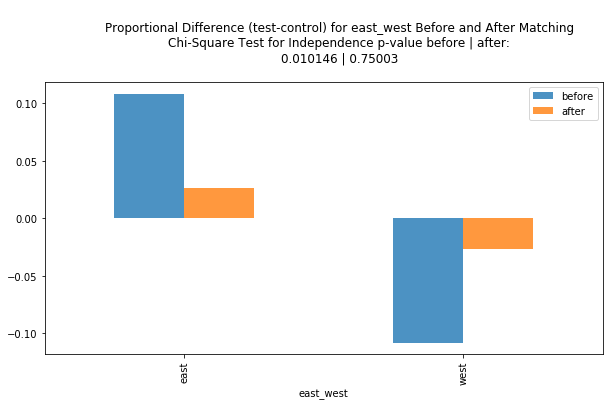

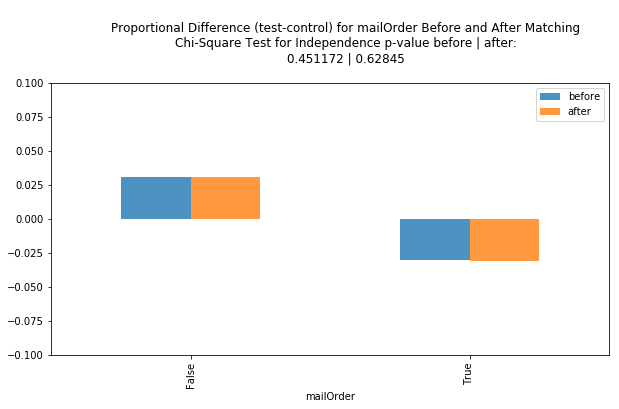

In [41]:
match.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,monthlyIncome,0.000,0.220,1.000,1.000,-0.574041,0.000000,-0.474429,-0.137615
1,age,0.169,0.602,0.495,0.863,0.097015,0.046139,0.180693,0.080194
2,relocation,0.170,0.781,1.000,1.000,0.000000,0.000000,0.089268,-0.032276
3,request,0.057,0.919,0.107,0.313,-0.230135,-0.243540,-0.199752,-0.092021
4,banking_connection,0.850,0.520,1.000,1.000,0.000000,0.000000,-0.013719,-0.131073
5,business_relation,0.409,0.831,1.000,1.000,0.000000,0.000000,-0.071285,-0.040363
6,conditions,0.068,0.384,1.000,1.000,0.000000,0.000000,-0.141863,-0.153835
7,credit_card,0.903,0.617,1.000,1.000,0.000000,0.000000,-0.069275,-0.153392
8,giro,0.310,0.335,1.000,1.000,0.000000,0.000000,-0.107940,-0.125512
9,global_credit,0.596,0.170,1.000,1.000,0.000000,0.000000,0.033671,0.176141


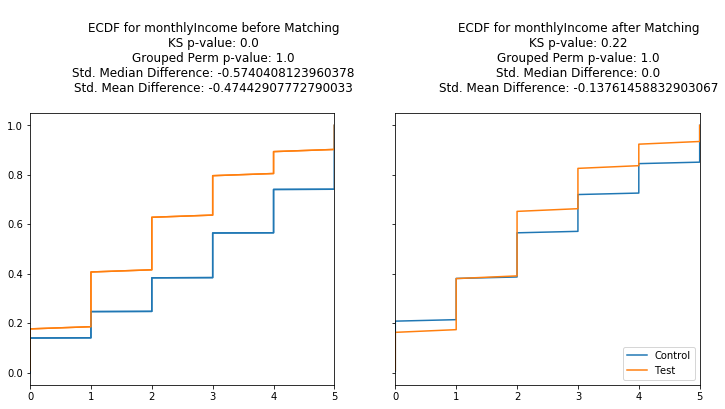

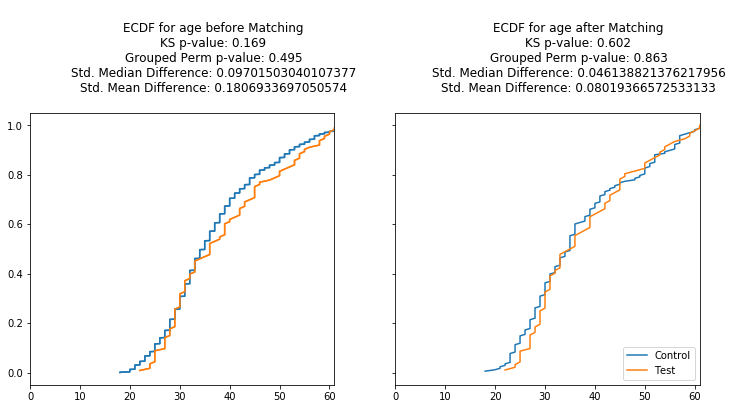

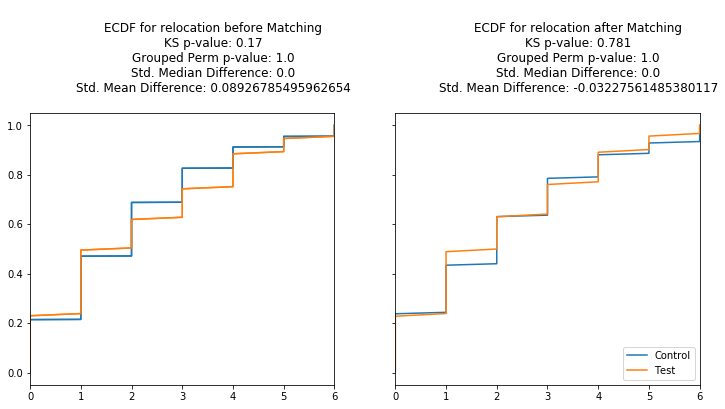

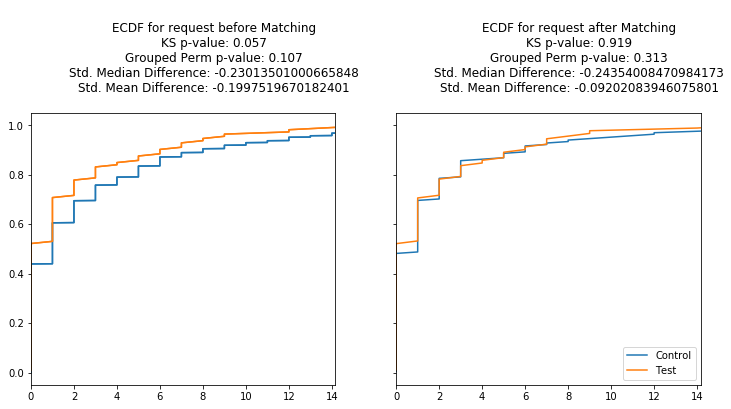

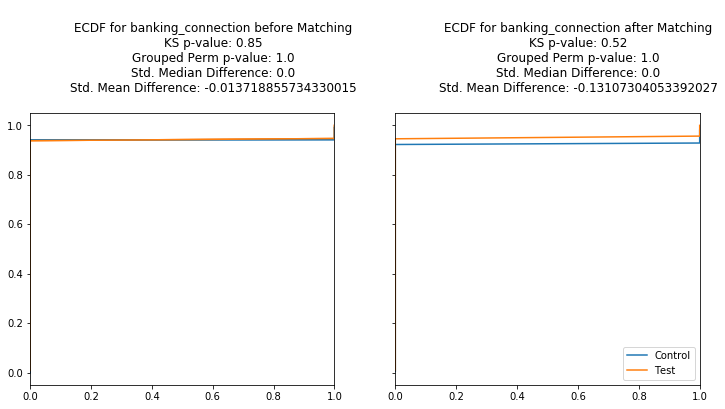

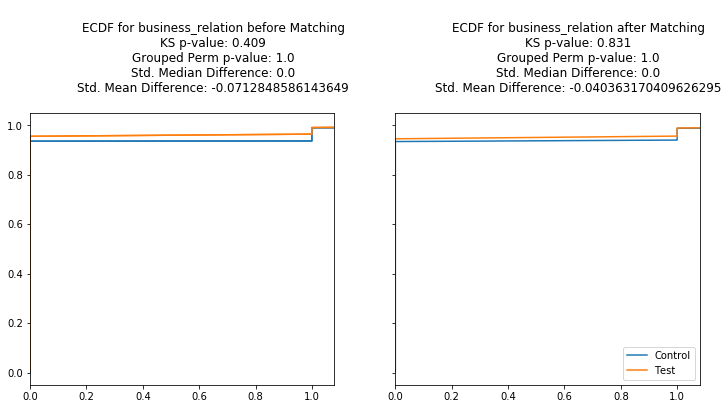

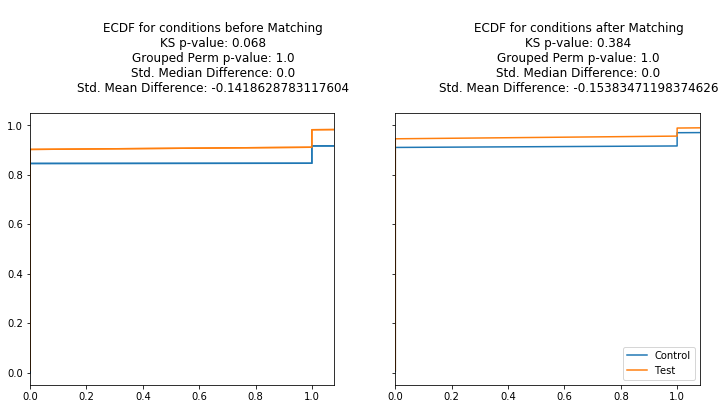

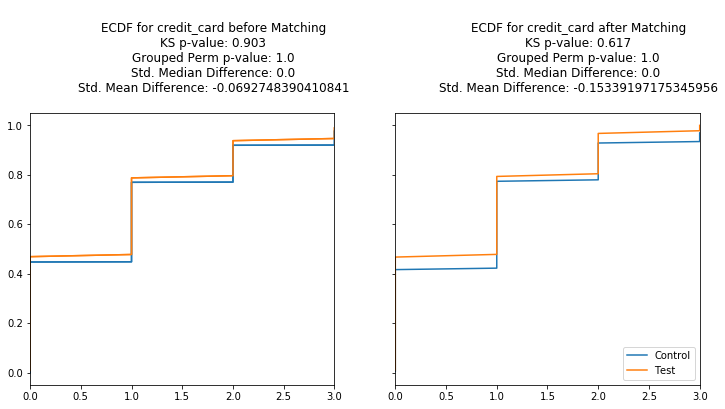

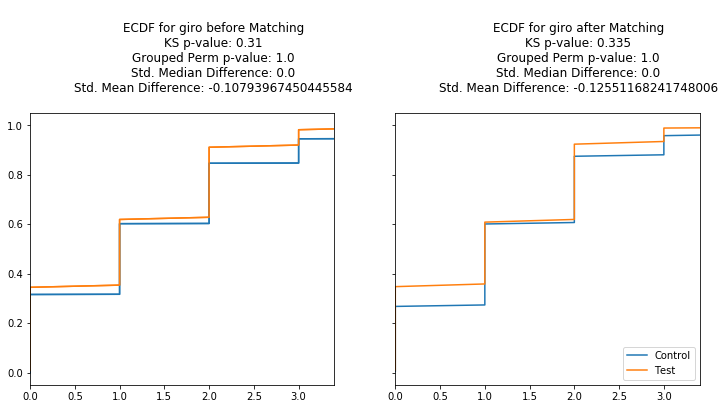

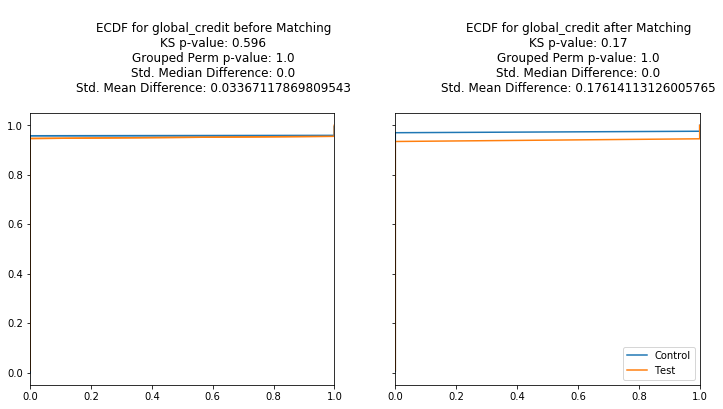

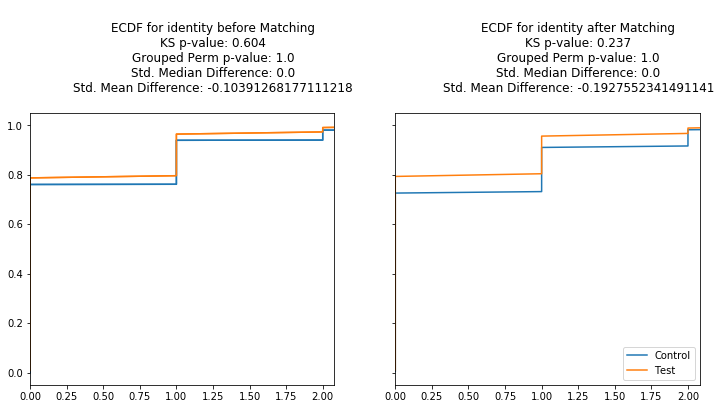

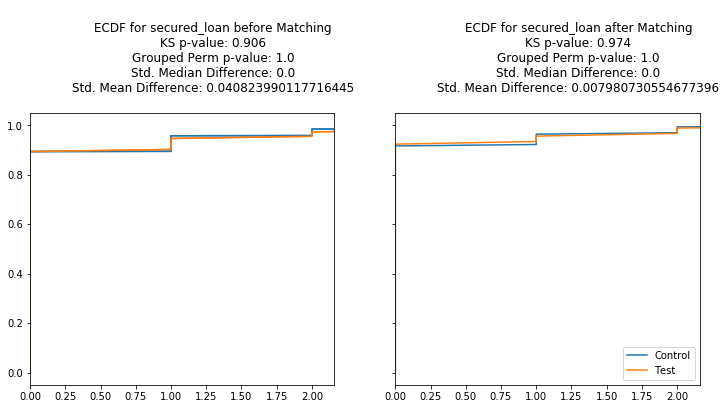

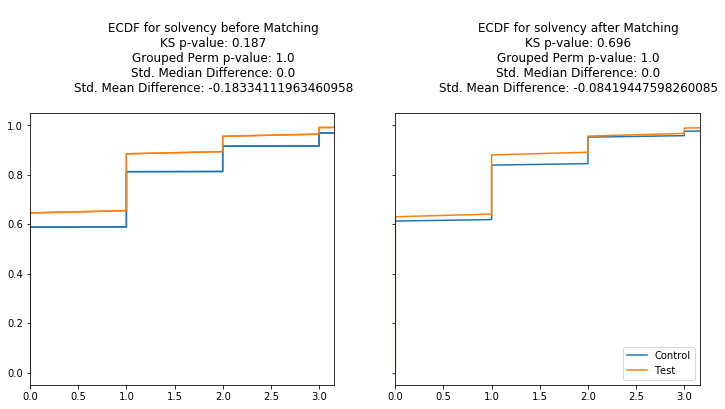

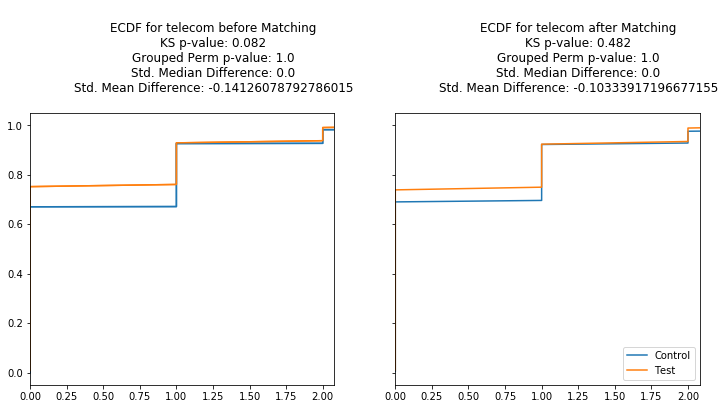

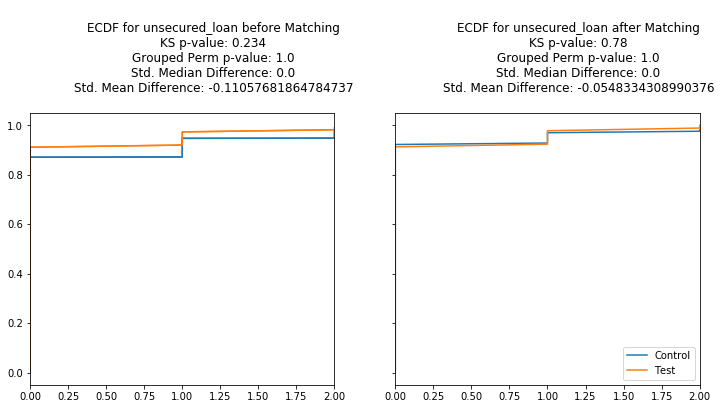

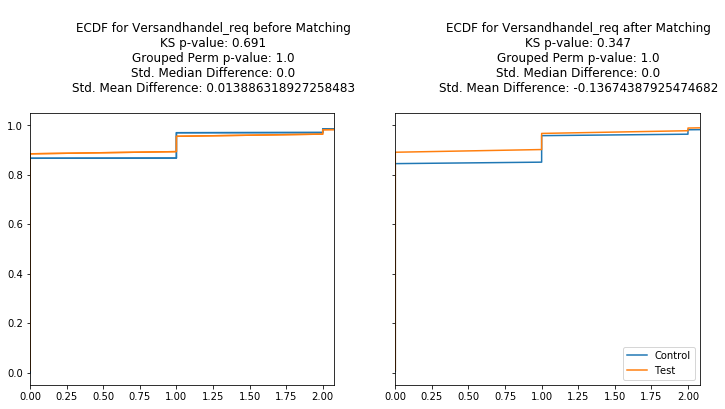

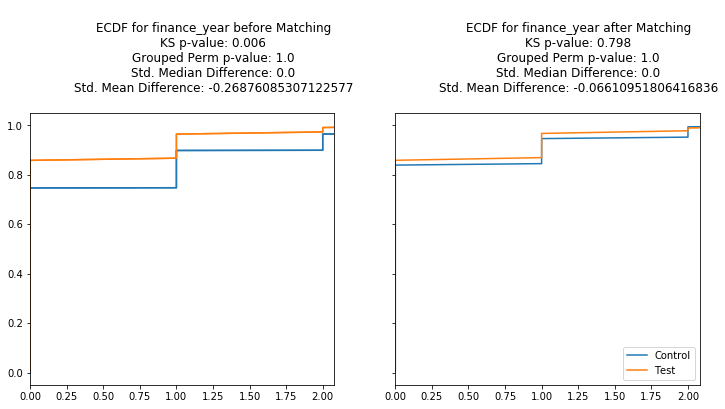

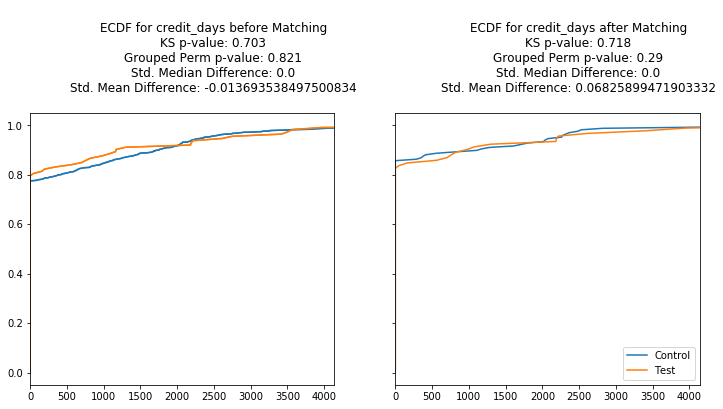

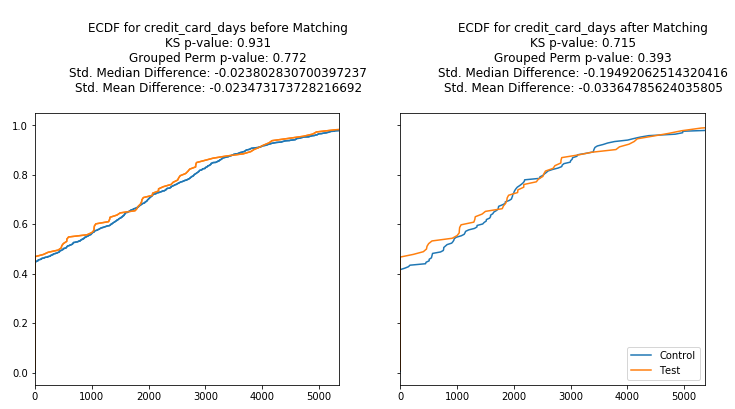

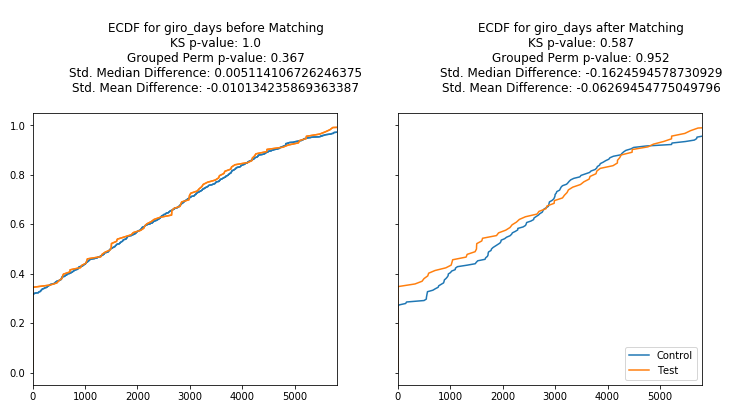

In [42]:
match.compare_continuous(return_table=True)

The distribution before and after the matching are relativly similar, even though the matching procedure helped making them even more equal.

In [43]:
match.matched_data.shape

(260, 28)

In [44]:
subsample = Xy.set_index("id").loc[match.matched_data["id"]]
subsample.shape

(260, 24)

In [45]:
subsample = subsample.join(match.matched_data.set_index('id')["weight"], on="id")

In [46]:
subsample.shape

(260, 25)

## Do Matching for all variables per sector score & version

In [47]:
# ATTENTION: We need to analyse correlation and match subsamples for each Score branch/version!!!

In [48]:
df_data.iloc[:,-26:].columns

Index(['request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       'Freiberufler_req', 'Genossenschaftsbanken_req', 'Handel_req',
       'Hypothekengeschäft_req', 'Kleingewerbetreibende_req', 'Sparkassen_req',
       'Sparkassen/Genossenschaftsbanken_req',
       'Telekommunikationsunternehmen_req', 'Versandhandel_req', 'credit_days',
       'credit_card_days', 'giro_days', 'finance_year'],
      dtype='object')

In [49]:
def create_subsample(domain, version, df, covariates, treatment="sex", ordered_attr=["male", "female"], nmatches=1, thresh=0.001):
    
    data = df[(df["domain"]==domain) & (df["version"]==version)]
    
    data.iloc[:, -26:] = data.iloc[:, -26:].fillna(0)
    
    df_match = data[covariates + [treatment]].dropna()
    
    print("Columns that are used in matching (including the treatment-variable):", df_match.columns)
    
    # We included monthlyIncome and need to convert it to numerical
    df_match.monthlyIncome = df_match.monthlyIncome.cat.codes

    #df_match[treatment].cat.categories = ordered_attr
    print(df_match[treatment].head())
    print(df_match[treatment].cat.codes.head())
    if df_match[treatment].iloc[0]==ordered_attr[0] and df_match[treatment].cat.codes.iloc[0] == 1:
        print("------------")
        print("Needed to invert binary variable")
        print("------------")
        df_match[treatment] = df_match[treatment].cat.codes.apply(lambda x: abs(x-1))
    else:
        df_match[treatment] = df_match[treatment].cat.codes

    # Treatment-Group
    test = df_match[df_match[treatment]==1]
    # Control-Group
    control = df_match[df_match[treatment]==0]
    print("Sample sizes treat/control", test.shape, control.shape)

    match = Matcher(test=test, control=control, yvar=treatment, exclude=["id"])

    np.random.seed(42)

    # We subsample male because of significant class imbalance, 
    # therefore we fit multiple models with random subsamples of the control group
    match.fit_scores(balance=True, nmodels=150)

    match.predict_scores()

    match.plot_scores()

    # Use custom function with Nearest-Neighbours without replacement
    nn_without_replacement(match, nmatches=nmatches, thresh=thresh)
    add_weights(match, variable=treatment)
    
    # Train threshold for matching propensity-score
    #match.tune_threshold(method="min")
    # Threshold seems to be ignored with this method
    #match.match(method="min", nmatches=nmatches, threshold=0.0008)
    #match.matched_data.sort_values("match_id").head()

    # Select subsample according to the IDs equal in the matched set
    subsample = data.set_index("id").loc[match.matched_data["id"]]
    
    # Add Matching-Pair Weight
    subsample = subsample.join(match.matched_data.set_index('id')["weight"], on="id")
    print("Sample size of matched subsample:", subsample.shape)
    
    return subsample

In [50]:
def execute_matching(domain, version, df, covariates, treatment, ordered_attr, nmatches=1, thresh=0.0008):
    
    subsample = create_subsample(domain, version, df, 
                                 covariates+["id"], 
                                 treatment=treatment, 
                                 ordered_attr=ordered_attr, 
                                 nmatches=nmatches, thresh=thresh)
    
    print("\nu-Tests before matching")
    Xy = df[(df["domain"]==domain) & (df["version"]==version) & (df["monthlyIncome"].notna())]
    Xy.monthlyIncome = Xy.monthlyIncome.cat.codes
    do_utests(Xy, treatment, target+metric, [ordered_attr[1], ordered_attr[0]])

    subsample_analyse = subsample.copy()
    subsample_analyse.monthlyIncome = subsample_analyse.monthlyIncome.cat.codes

    print("\nu-Tests after matching")
    do_utests(subsample_analyse, treatment, metric, [ordered_attr[1], ordered_attr[0]])

    print("\nu-Test for score and %s:"%treatment)
    do_utests(subsample_analyse, treatment, target, [ordered_attr[1], ordered_attr[0]])
    
    return subsample

### Matching for variable sex

In [51]:
table2 = prepare_type(table2)

In [52]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)

relevant_feats = target + nominal + metric

In [53]:
covariates = [feat for feat in relevant_feats if feat not in ["sex", "score"]]
covariates

['east_west',
 'mailOrder',
 'monthlyIncome',
 'age',
 'relocation',
 'request',
 'banking_connection',
 'business_relation',
 'conditions',
 'credit_card',
 'giro',
 'global_credit',
 'identity',
 'secured_loan',
 'solvency',
 'telecom',
 'unsecured_loan',
 'Versandhandel_req',
 'finance_year',
 'credit_days',
 'credit_card_days',
 'giro_days']

In [54]:
domain = "Versandhandel"
variable = "sex"
attributes = ["male", "female"]
nmatches = 3
thresh = 0.0008

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'sex'],
      dtype='object')
2    male
3    male
4    male
5    male
6    male
Name: sex, dtype: category
Categories (2, object): [female, male]
2    1
3    1
4    1
5    1
6    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (113, 24) (1142, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_c

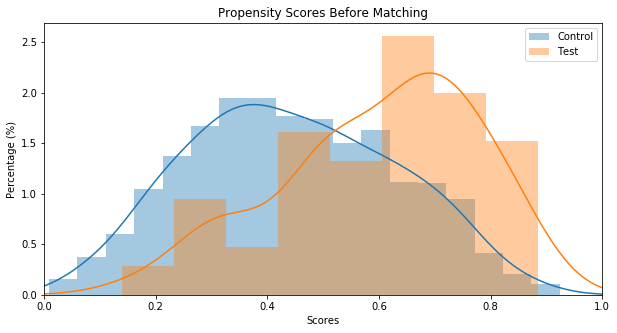

In [55]:
subsample_vs1 = execute_matching(domain, 1, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'sex'],
      dtype='object')
1617    male
1618    male
1619    male
1620    male
1621    male
Name: sex, dtype: category
Categories (2, object): [female, male]
1617    1
1618    1
1619    1
1620    1
1621    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (127, 24) (1168, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+fin

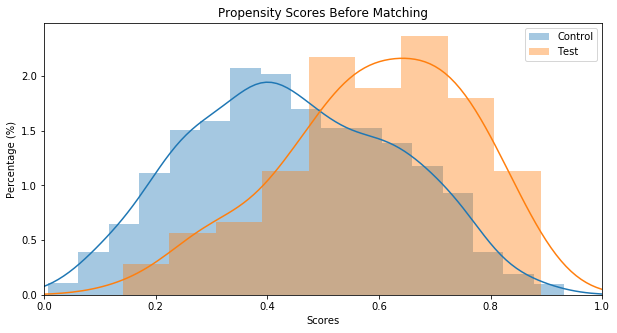

In [56]:
subsample_vs2 = execute_matching(domain, 2, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'sex'],
      dtype='object')
3281    male
3282    male
3283    male
3284    male
3285    male
Name: sex, dtype: category
Categories (2, object): [female, male]
3281    1
3282    1
3283    1
3284    1
3285    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (115, 24) (1187, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+fin

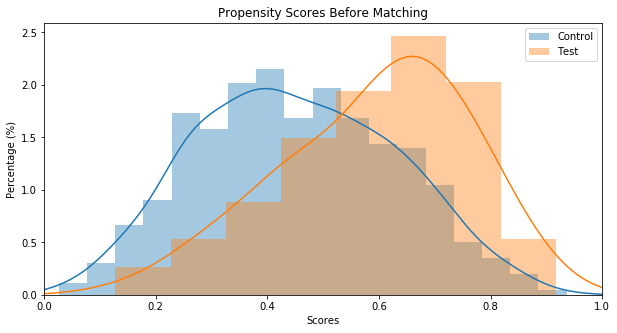

In [57]:
subsample_vs3 = execute_matching(domain, 3, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

In [58]:
domain = "Banken"

nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

covariates = [feat for feat in relevant_feats if feat not in [variable, "score"]]

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'sex'],
      dtype='object')
4952    male
4953    male
4954    male
4955    male
4956    male
Name: sex, dtype: category
Categories (2, object): [female, male]
4952    1
4953    1
4954    1
4955    1
4956    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (109, 24) (1163, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days

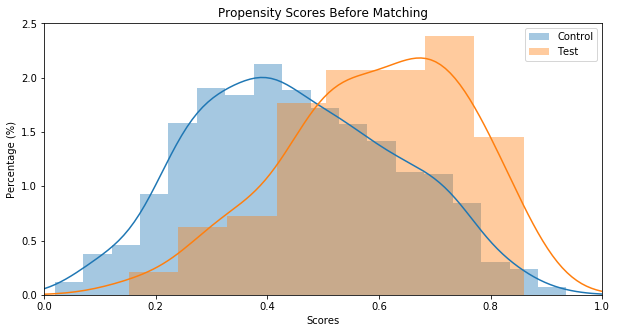

In [59]:
subsample_b1 = execute_matching(domain, 1, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'sex'],
      dtype='object')
6585    male
6586    male
6587    male
6588    male
6589    male
Name: sex, dtype: category
Categories (2, object): [female, male]
6585    1
6586    1
6587    1
6588    1
6589    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (120, 24) (1169, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days

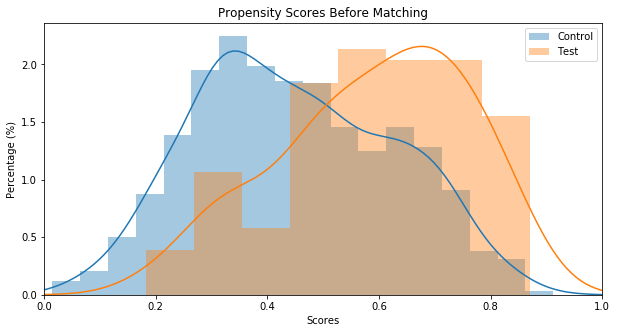

In [60]:
subsample_b2 = execute_matching(domain, 2, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['east_west', 'mailOrder', 'monthlyIncome', 'age', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'sex'],
      dtype='object')
8228    male
8229    male
8230    male
8231    male
8232    male
Name: sex, dtype: category
Categories (2, object): [female, male]
8228    1
8229    1
8230    1
8231    1
8232    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (115, 24) (1106, 24)
Formula:
sex ~ east_west+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days

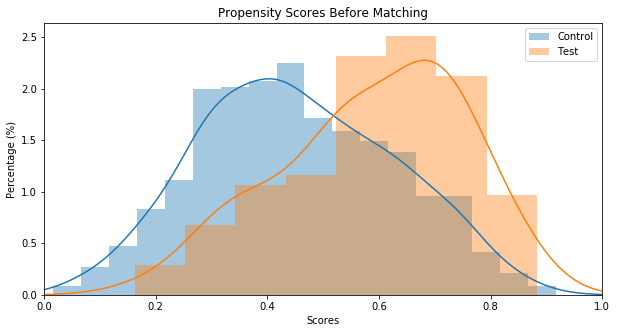

In [61]:
subsample_b3 = execute_matching(domain, 3, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

In [62]:
# append all subsamples:

In [63]:
subsample_sex = subsample_vs1.append([subsample_vs2, subsample_vs3, subsample_b1, subsample_b2, subsample_b3], sort=False)

In [64]:
subsample_sex.shape, subsample_sex.columns

((1786, 74),
 Index(['date', 'table', 'customer', 'feature', 'domain', 'version', 'score',
        'value', 'level', 'meaning', 'stoerung', 'kredit_jahr',
        'kredit_nutzung', 'kredit_historie', 'allgemein', 'anschrift',
        'all_columns_text', 'activeLoanAmount', 'admonition', 'cashing',
        'employment', 'executionProceedings', 'familyStatus', 'housing',
        'insolvencyProceedings', 'mailOrder', 'migrationBackground',
        'monthlyIncome', 'numberOfActiveLoans', 'numberOfChildren',
        'numberOfCreditCards', 'numberOfGiroAccounts',
        'numberOfMobileContracts', 'numberOfPaidOffLoans', 'paidOffLoanAmount',
        'plz', 'relocation', 'schufaDate', 'sex', 'yearOfBirth', 'foreigner',
        'basisscore', 'plz_one', 'east_west', 'age', 'age_class', 'age_gen',
        'request', 'banking_connection', 'business_relation', 'conditions',
        'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
        'solvency', 'telecom', 'unsecured_loan', 

In [65]:
subsample_sex.to_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_sex.csv", index=True, sep=";")

## Matching for east_west

In [66]:
domain = "Versandhandel"
variable = "east_west"
attributes = ["west", "east"]
nmatches = 3
thresh = 0.0008

In [67]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

covariates = [feat for feat in relevant_feats if feat not in [variable, "score"]]

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Versandhandel_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
2    west
3    west
4    west
5    west
6    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
2    1
3    1
4    1
5    1
6    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (265, 24) (990, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_card_

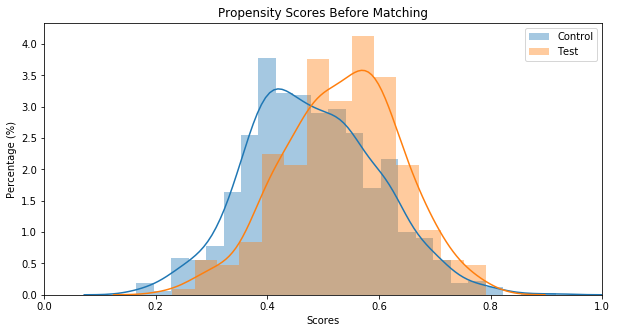

In [68]:
subsample_vs1 = execute_matching(domain, 1, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Versandhandel_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
1617    west
1618    west
1619    west
1620    west
1621    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
1617    1
1618    1
1619    1
1620    1
1621    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (271, 24) (1024, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+financ

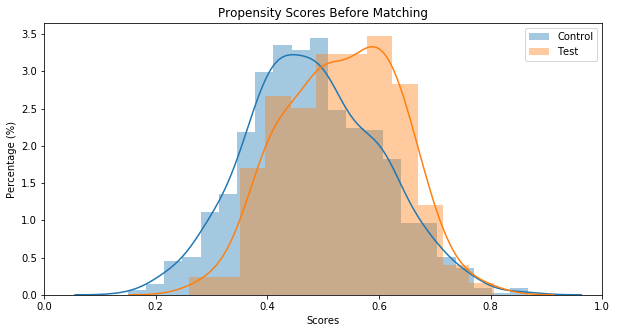

In [69]:
subsample_vs2 = execute_matching(domain, 2, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Versandhandel_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
3281    west
3282    west
3283    west
3284    west
3285    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
3281    1
3282    1
3283    1
3284    1
3285    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (266, 24) (1036, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+financ

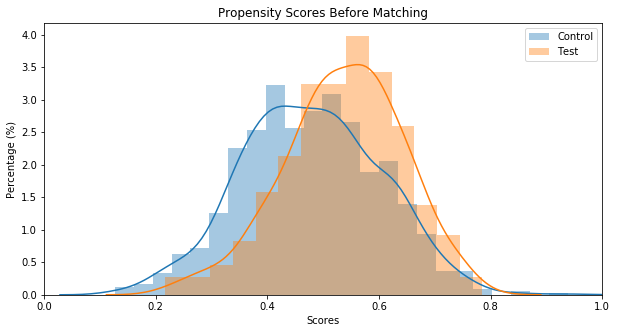

In [70]:
subsample_vs3 = execute_matching(domain, 3, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

In [71]:
domain = "Banken"

In [72]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

covariates = [feat for feat in relevant_feats if feat not in [variable, "score"]]

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
4952    west
4953    west
4954    west
4955    west
4956    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
4952    1
4953    1
4954    1
4955    1
4956    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (276, 24) (996, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_d

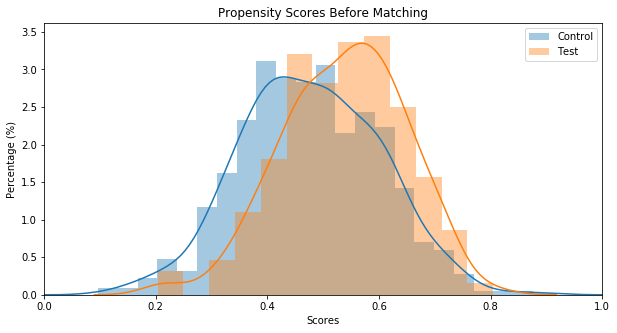

In [73]:
subsample_b1 = execute_matching(domain, 1, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
6585    west
6586    west
6587    west
6588    west
6589    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
6585    1
6586    1
6587    1
6588    1
6589    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (277, 24) (1012, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_

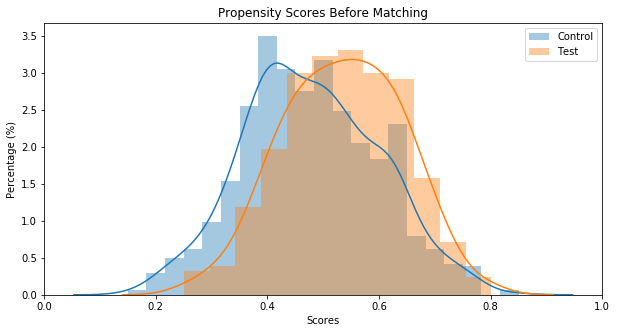

In [74]:
subsample_b2 = execute_matching(domain, 2, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'mailOrder', 'monthlyIncome', 'age', 'relocation', 'request',
       'banking_connection', 'business_relation', 'conditions', 'credit_card',
       'giro', 'global_credit', 'identity', 'secured_loan', 'solvency',
       'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'east_west'],
      dtype='object')
8228    west
8229    west
8230    west
8231    west
8232    west
Name: east_west, dtype: category
Categories (2, object): [east, west]
8228    1
8229    1
8230    1
8231    1
8232    1
dtype: int8
------------
Needed to invert binary variable
------------
Sample sizes treat/control (249, 24) (972, 24)
Formula:
east_west ~ sex+mailOrder+monthlyIncome+age+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_d

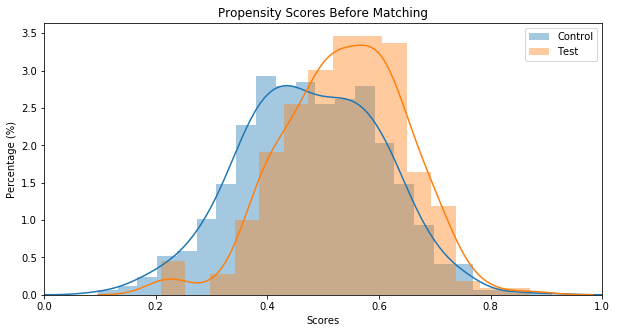

In [75]:
subsample_b3 = execute_matching(domain, 3, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

In [76]:
# append all subsamples:

In [77]:
subsample_east_west = subsample_vs1.append([subsample_vs2, subsample_vs3, subsample_b1, subsample_b2, subsample_b3], sort=False)

In [78]:
subsample_east_west.shape, subsample_east_west.columns

((4218, 74),
 Index(['date', 'table', 'customer', 'feature', 'domain', 'version', 'score',
        'value', 'level', 'meaning', 'stoerung', 'kredit_jahr',
        'kredit_nutzung', 'kredit_historie', 'allgemein', 'anschrift',
        'all_columns_text', 'activeLoanAmount', 'admonition', 'cashing',
        'employment', 'executionProceedings', 'familyStatus', 'housing',
        'insolvencyProceedings', 'mailOrder', 'migrationBackground',
        'monthlyIncome', 'numberOfActiveLoans', 'numberOfChildren',
        'numberOfCreditCards', 'numberOfGiroAccounts',
        'numberOfMobileContracts', 'numberOfPaidOffLoans', 'paidOffLoanAmount',
        'plz', 'relocation', 'schufaDate', 'sex', 'yearOfBirth', 'foreigner',
        'basisscore', 'plz_one', 'east_west', 'age', 'age_class', 'age_gen',
        'request', 'banking_connection', 'business_relation', 'conditions',
        'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
        'solvency', 'telecom', 'unsecured_loan', 

In [79]:
subsample_east_west.to_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_east_west.csv", index=True, sep=";")

## Matching for age

In [80]:
def binarize_age(row):
    if row < 40:
        return "<40"
    else:
        return ">=40"

table2.insert(15, "bin_age", table2.age.apply(binarize_age))
table2["bin_age"] = table2["bin_age"].astype("category")
table2.bin_age.head()

0    >=40
1    >=40
2    >=40
3    >=40
4     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]

In [81]:
table2.iloc[:,-26:].columns

Index(['request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       'Freiberufler_req', 'Genossenschaftsbanken_req', 'Handel_req',
       'Hypothekengeschäft_req', 'Kleingewerbetreibende_req', 'Sparkassen_req',
       'Sparkassen/Genossenschaftsbanken_req',
       'Telekommunikationsunternehmen_req', 'Versandhandel_req', 'credit_days',
       'credit_card_days', 'giro_days', 'finance_year'],
      dtype='object')

In [82]:
domain = "Versandhandel"
variable = "bin_age"
attributes = ["<40", ">=40"]
nmatches = 2
thresh = 0.0008

In [83]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

covariates = [feat for feat in relevant_feats if feat not in [variable, "age", "score"]]

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'bin_age'],
      dtype='object')
2    >=40
3    >=40
4     <40
5     <40
6     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
2    1
3    1
4    0
5    0
6    0
dtype: int8
Sample sizes treat/control (418, 24) (837, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_card_days+giro_days
n majority: 837
n minority: 418


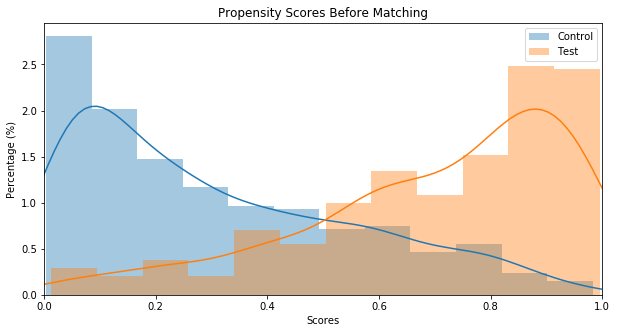

In [84]:
subsample_vs1 = execute_matching(domain, 1, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'bin_age'],
      dtype='object')
1617    >=40
1618    >=40
1619     <40
1620     <40
1621     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
1617    1
1618    1
1619    0
1620    0
1621    0
dtype: int8
Sample sizes treat/control (431, 24) (864, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_card_days+giro_days
n 

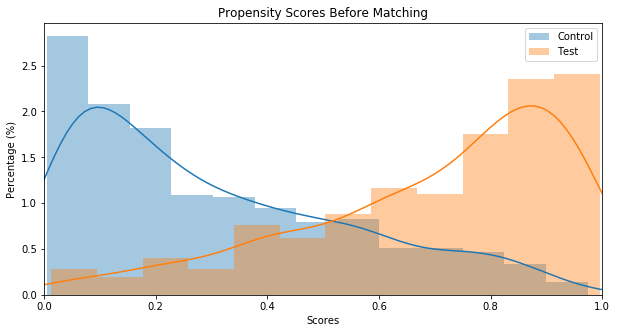

In [85]:
subsample_vs2 = execute_matching(domain, 2, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Versandhandel_req',
       'finance_year', 'credit_days', 'credit_card_days', 'giro_days', 'id',
       'bin_age'],
      dtype='object')
3281    >=40
3282    >=40
3283     <40
3284     <40
3285     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
3281    1
3282    1
3283    0
3284    0
3285    0
dtype: int8
Sample sizes treat/control (442, 24) (860, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Versandhandel_req+finance_year+credit_days+credit_card_days+giro_days
n 

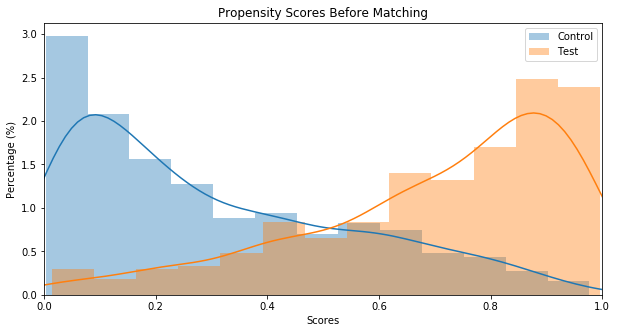

In [86]:
subsample_vs3 = execute_matching(domain, 3, table2, covariates, 
                                 treatment=variable,
                                 ordered_attr=attributes, 
                                 nmatches=nmatches, thresh=thresh)

In [87]:
domain = "Banken"

In [88]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

covariates = [feat for feat in relevant_feats if feat not in [variable, "age", "score"]]

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'bin_age'],
      dtype='object')
4952    >=40
4953    >=40
4954     <40
4955     <40
4956     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
4952    1
4953    1
4954    0
4955    0
4956    0
dtype: int8
Sample sizes treat/control (419, 24) (853, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days+credit_card_days+giro_days
n majority: 853
n minor

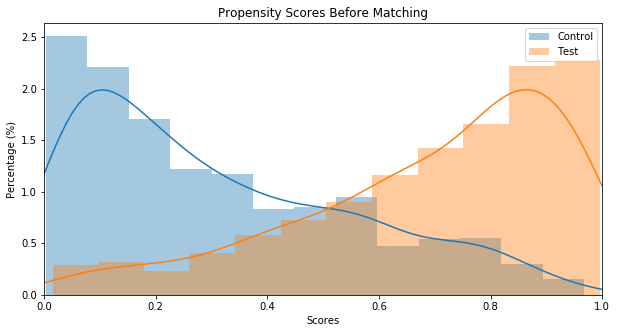

In [89]:
subsample_b1 = execute_matching(domain, 1, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'bin_age'],
      dtype='object')
6585    >=40
6586    >=40
6587     <40
6588     <40
6589     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
6585    1
6586    1
6587    0
6588    0
6589    0
dtype: int8
Sample sizes treat/control (428, 24) (861, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days+credit_card_days+giro_days
n majority: 861
n minor

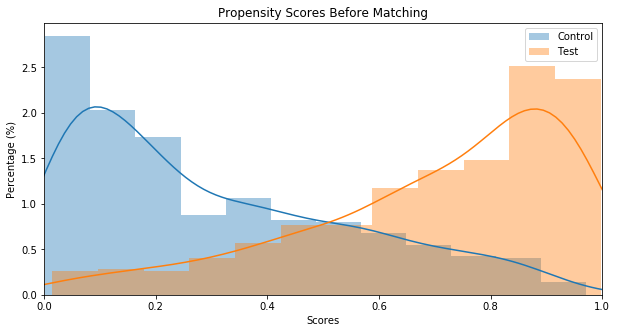

In [90]:
subsample_b2 = execute_matching(domain, 2, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

Columns that are used in matching (including the treatment-variable): Index(['sex', 'east_west', 'mailOrder', 'monthlyIncome', 'relocation',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req', 'finance_year',
       'credit_days', 'credit_card_days', 'giro_days', 'id', 'bin_age'],
      dtype='object')
8228    >=40
8229    >=40
8230     <40
8231     <40
8232     <40
Name: bin_age, dtype: category
Categories (2, object): [<40, >=40]
8228    1
8229    1
8230    0
8231    0
8232    0
dtype: int8
Sample sizes treat/control (413, 24) (808, 24)
Formula:
bin_age ~ sex+east_west+mailOrder+monthlyIncome+relocation+request+banking_connection+business_relation+conditions+credit_card+giro+global_credit+identity+secured_loan+solvency+telecom+unsecured_loan+Banken_req+finance_year+credit_days+credit_card_days+giro_days
n majority: 808
n minor

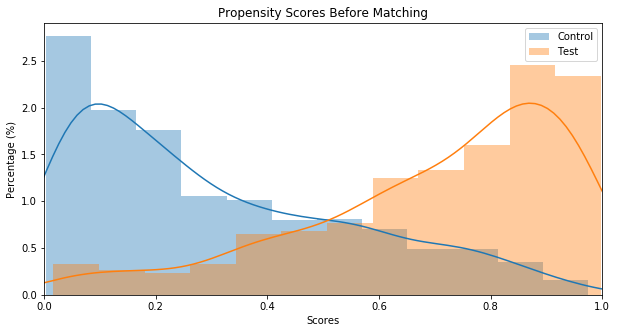

In [91]:
subsample_b3 = execute_matching(domain, 3, table2, covariates, 
                                treatment=variable,
                                ordered_attr=attributes, 
                                nmatches=nmatches, thresh=thresh)

In [92]:
# append all subsamples:

In [93]:
subsample_age = subsample_vs1.append([subsample_vs2, subsample_vs3, subsample_b1, subsample_b2, subsample_b3], sort=False)

In [94]:
subsample_age.shape, subsample_age.columns

((2293, 75),
 Index(['date', 'table', 'customer', 'feature', 'domain', 'version', 'score',
        'value', 'level', 'meaning', 'stoerung', 'kredit_jahr',
        'kredit_nutzung', 'kredit_historie', 'bin_age', 'allgemein',
        'anschrift', 'all_columns_text', 'activeLoanAmount', 'admonition',
        'cashing', 'employment', 'executionProceedings', 'familyStatus',
        'housing', 'insolvencyProceedings', 'mailOrder', 'migrationBackground',
        'monthlyIncome', 'numberOfActiveLoans', 'numberOfChildren',
        'numberOfCreditCards', 'numberOfGiroAccounts',
        'numberOfMobileContracts', 'numberOfPaidOffLoans', 'paidOffLoanAmount',
        'plz', 'relocation', 'schufaDate', 'sex', 'yearOfBirth', 'foreigner',
        'basisscore', 'plz_one', 'east_west', 'age', 'age_class', 'age_gen',
        'request', 'banking_connection', 'business_relation', 'conditions',
        'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
        'solvency', 'telecom', 'unsecu

In [95]:
subsample_age.to_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_age.csv", index=True, sep=";")